In [1]:
suppressMessages(library("readxl"))
suppressMessages(library("fBasics"))
suppressMessages(library("quantmod"))
suppressMessages(library("fGarch"))
suppressMessages(library("forecast"))
suppressMessages(library("tseries"))
suppressMessages(library("rugarch"))
suppressMessages(library("strucchange"))
suppressMessages(library("urca"))
suppressMessages(library("vars"))
suppressMessages(library("dynlm"))
suppressMessages(library("sandwich"))
suppressMessages(library("zoo"))
suppressMessages(library("tidyverse"))
suppressMessages(library("tsDyn"))
suppressMessages(library("FinTS"))
suppressMessages(library("lmtest"))
suppressMessages(library(ggplot2))

INTRODUCTION 

In this work we aim to model the performance of NASDAQ which is a stock exchange opened in 1971, currently the second largest stock market in the United States, by volume traded, behind the New York Stock Exchange. It is the largest electronic stock market in the world. 
We used the ARIMA model for the analysis of the company's historical data and thanks to this same model had forecasts.



Methodology 

The historical data of NASDAQ is the opening, closing, low and high price of the company's stock. This data is daily and covers the period from 2018-01-02 to 2022-08-05. Our analysis focused on the Adj.close column. 
The adjusted closing price changes the closing price of a stock to reflect the value of that stock after any stock is accounted for. It is often used when reviewing historical performance or a detailed analysis of past performance.


In [2]:
library(readr)

all_data <- read_csv("IXIC.csv")
head(all_data)

Rows: 1157 Columns: 7
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,Open,High,Low,Close,Adj Close,Volume
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,6937.65,7006.91,6924.08,7006.90,7006.90,1914930000
2018-01-03,7017.07,7069.15,7016.70,7065.53,7065.53,2166780000
2018-01-04,7089.50,7098.05,7072.38,7077.91,7077.91,2098890000
2018-01-05,7105.74,7137.04,7097.08,7136.56,7136.56,2020900000
2018-01-08,7135.38,7161.35,7124.09,7157.39,7157.39,2051430000
2018-01-09,7174.19,7181.14,7148.30,7163.58,7163.58,2107300000


In [3]:
summary(all_data)


      Date                 Open            High            Low       
 Min.   :2018-01-02   Min.   : 6258   Min.   : 6355   Min.   : 6190  
 1st Qu.:2019-02-27   1st Qu.: 7766   1st Qu.: 7826   1st Qu.: 7717  
 Median :2020-04-21   Median : 9301   Median : 9325   Median : 9226  
 Mean   :2020-04-19   Mean   :10360   Mean   :10436   Mean   :10273  
 3rd Qu.:2021-06-14   3rd Qu.:13263   3rd Qu.:13399   3rd Qu.:13079  
 Max.   :2022-08-05   Max.   :16121   Max.   :16212   Max.   :16017  
     Close         Adj Close         Volume         
 Min.   : 6193   Min.   : 6193   Min.   :1.494e+08  
 1st Qu.: 7785   1st Qu.: 7785   1st Qu.:2.183e+09  
 Median : 9275   Median : 9275   Median :3.575e+09  
 Mean   :10360   Mean   :10360   Mean   :3.580e+09  
 3rd Qu.:13247   3rd Qu.:13247   3rd Qu.:4.601e+09  
 Max.   :16057   Max.   :16057   Max.   :1.110e+10  

 ARIMA model
ARIMA stands for Auto-Regressive Integrated Moving Average. It is also known as the Box-Jenkins approach. It is one of the most popular techniques used for time series analysis and forecasting purposes. The ARIMA model has two components:
1.	Autoregressive component
2.	Moving average component

1.	Auto-regressive component

It involves the relationship of a value of a series at a given time with its own previous values. Such a relationship can exist with any lag order. The lag is essentially a value at a previous time. It can have different orders.

2.	Moving average component
The moving average is the average of consecutive values at different periods. It can have different orders.

The auto-regressive (lag-based) and moving average components are used together by the ARIMA technique to forecast a time series.

The modeling process with the ARIMA model can be presented as follows: 






In [4]:
![Processus de modélisation avec Arima](arimaflowchart.png)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:2: unexpected '['
1: ![
     ^



1.   Graph of Adj.close evolution during the study period

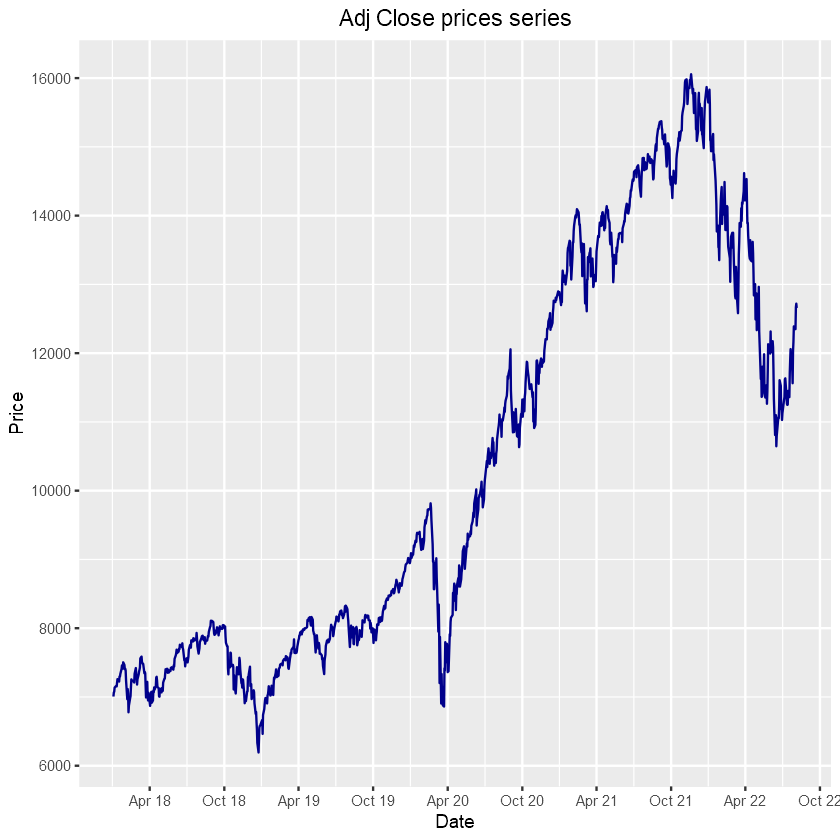

In [5]:
ggplot(all_data, aes(x = Date, y = `Adj Close`)) + geom_line(color = "darkblue") + ggtitle("Adj Close prices series") + xlab("Date") + ylab("Price") + theme(plot.title = element_text(hjust = 0.5)) + scale_x_date(date_labels = "%b %y", date_breaks = "6 months")

The NASDAQ Adj.close time series graph shows an upward trend over time.
There is no evidence of variance variation, so we will not do a Box-Cox transformation.
The data are clearly non-stationary, as the series moves up and down for long periods of time.

In technical analysis of stocks, a widely used technique is to plot moving averages on price charts. A simple moving average is an arithmetic average of the last
q days from an Xt series in the t time period. Thus, the moving average MUN qt
is given by:

In [6]:
pbr_mm <- subset(all_data,all_data$Date >= "2020-01-01")

pbr_mm10 <- rollmean(pbr_mm[,6], 10, fill = list(NA, NULL, NA), align = "right")
pbr_mm30 <- rollmean(pbr_mm[,6], 30, fill = list(NA, NULL, NA), align = "right")

pbr_mm$mm10 <- coredata(pbr_mm10)
pbr_mm$mm30 <- coredata(pbr_mm30)

Warning message:
"Use of `pbr_mm$mm10` is discouraged. Use `mm10` instead."
Warning message:
"Use of `pbr_mm$mm30` is discouraged. Use `mm30` instead."
Warning message:
"Removed 9 row(s) containing missing values (geom_path)."
Warning message:
"Removed 29 row(s) containing missing values (geom_path)."


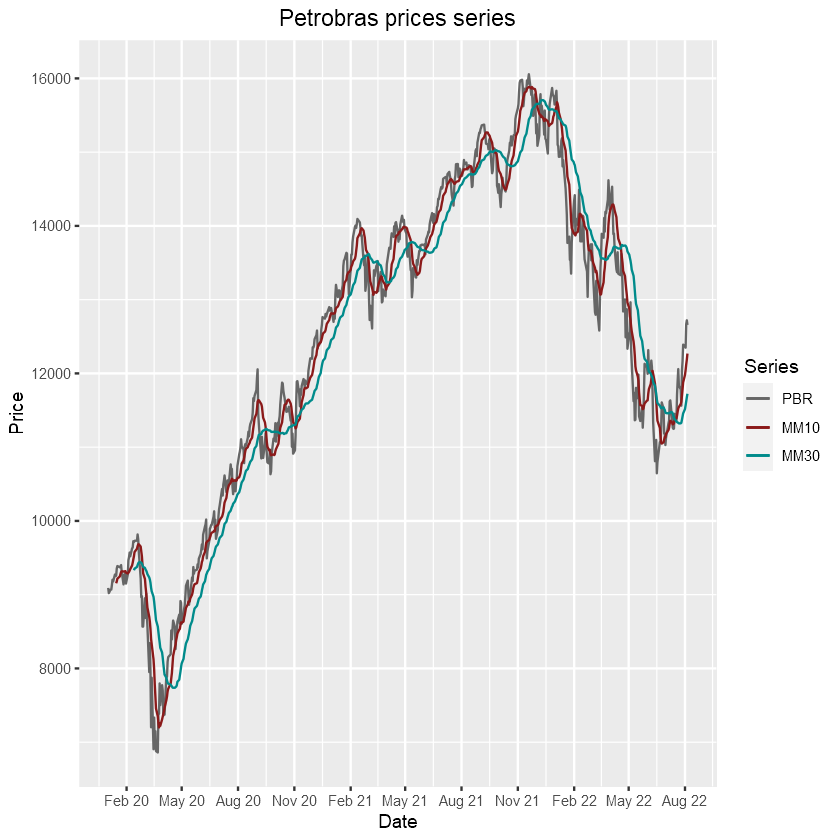

In [7]:
ggplot(pbr_mm, aes(x = Date)) +
  geom_line(aes(y = `Adj Close`, color = "PBR")) + ggtitle("Petrobras prices series") +
  geom_line(aes(y = pbr_mm$mm10, color = "MM10")) +
  geom_line(aes(y = pbr_mm$mm30, color = "MM30")) + xlab("Date") + ylab("Price") +
  theme(plot.title = element_text(hjust = 0.5), panel.border = element_blank()) +
  scale_x_date(date_labels = "%b %y", date_breaks = "3 months") +
  scale_colour_manual("Series", values=c("PBR"="gray40", "MM10"="firebrick4", "MM30"="darkcyan"))

We have seen how stock prices have changed over time. Now we will check how the stock returns have behaved over the same period. To do this, we first need to create a new object with the calculated returns, using the adjusted price column :


The stationarity of the data can be known by applying the unit root tests - Augmented Dickey-Fuller (ADF) test.
The null hypothesis for an ADF test is that the data are not stationary. Thus, a p-value greater than 0.05 indicates non-stationarity and p-values less than 0.05 suggest stationarity.


In [8]:
adf = adf.test(all_data$`Adj Close`)

adf


	Augmented Dickey-Fuller Test

data:  all_data$`Adj Close`
Dickey-Fuller = -1.6494, Lag order = 10, p-value = 0.7267
alternative hypothesis: stationary


pvalue >0.5 then our data from Adj.close is non-stationary.

Since the series is non-stationary we use differentiation - calculating the differences between consecutive observations.

Let's use the functions ndiffs(),diff() to find the number of times the difference needed for the data and to differentiate the data respectively.

In [9]:
# Number of Difference Required to make data stationary
ndiffs(all_data$`Adj Close`)

[1] 1

Thus, we need to differentiate the series once to make it stationary

In [10]:
diff_data = ts(diff(all_data$`Adj Close`, lag = 1))
adf.test(diff_data)

Warning message in adf.test(diff_data):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff_data
Dickey-Fuller = -9.7226, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



Thus, we have just stationed our series.

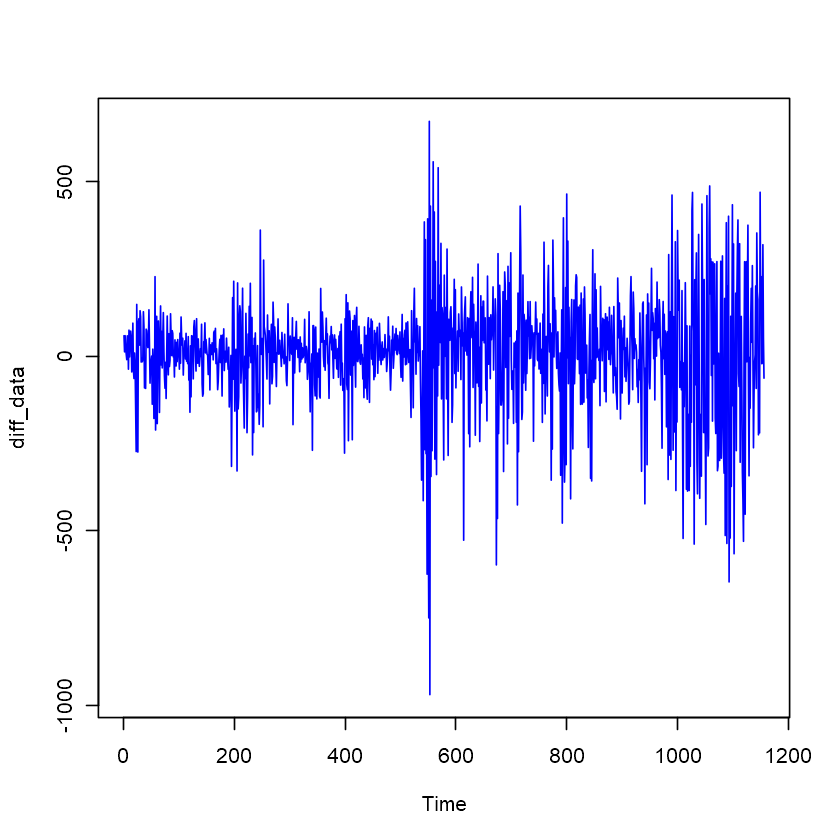

In [11]:
plot.ts(diff_data,col = "blue")

Model identification and estimation

We can do model identification in two ways:

1 . Using the ACF and PACF functions

2. Use of the minimum information criteria matrix

Method I: ACF and PACF functions

Autocorrelation function (ACF)

Autocorrelation is a correlation coefficient. However, instead of a correlation between two different variables, the correlation is between two values of the same variable at times Xt and Xt-h. Correlation between two or more lags.

If the time series is a moving average of order 1, called MA(1), we should only see one significant autocorrelation coefficient at lag 1. This is because an MA(1) process has a memory of only one period. If the time series is an MA(2), we should only see two significant autocorrelation coefficients, at lags 1 and 2, because an MA(2) process has a memory of only two periods.


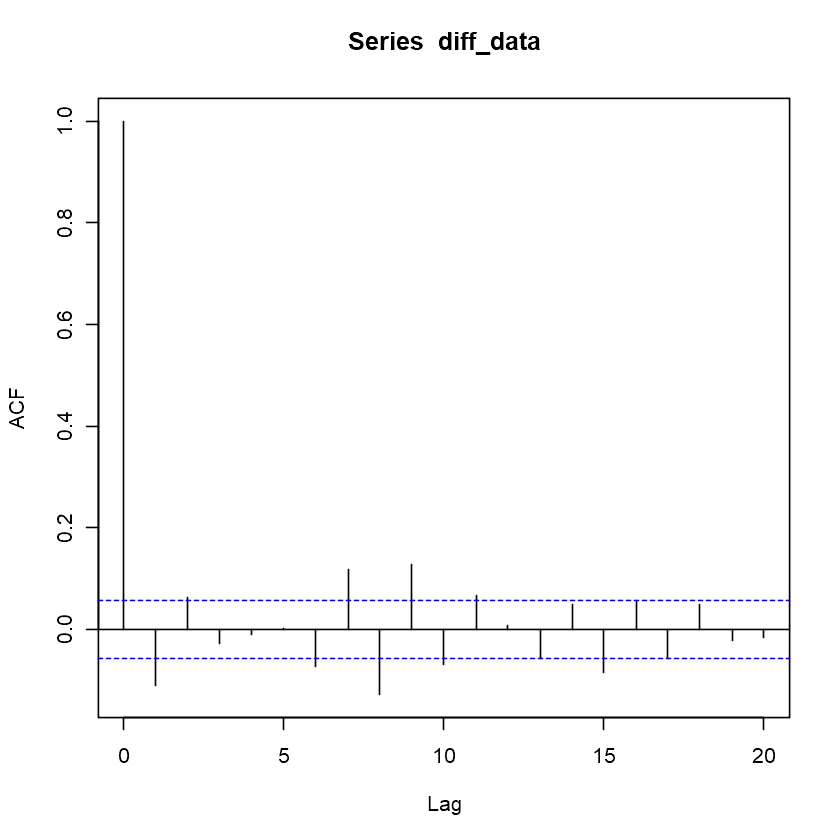

In [12]:
acf(diff_data, lag.max = 20)

The ACF graph suggests an MA(1) model

Partial autocorrelation function (PACF)

For a time series, the partial autocorrelation between xt and xt-h is defined as the conditional correlation between xt and xt-h, conditional on xt-h+1, ... , xt-1, the set of observations that lie between times t and t-h.

If the time series has an autoregressive order of 1, called AR(1), then only the first partial autocorrelation coefficient should be considered significant. If it has an AR(2), then only the first and second partial autocorrelation coefficients should be considered significant. 

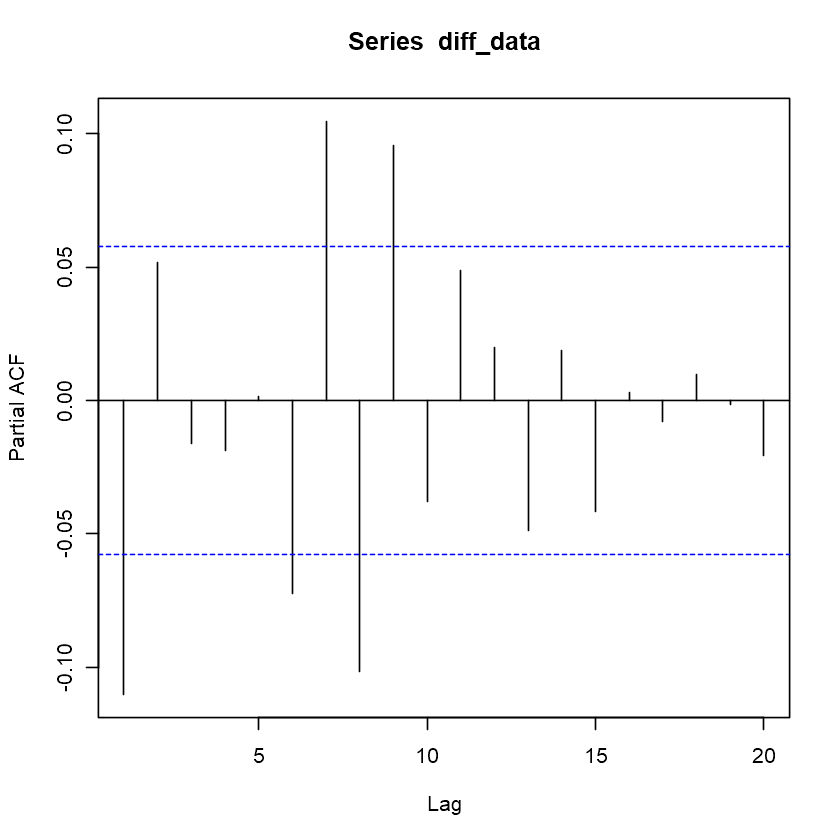

In [13]:
pacf(diff_data, lag.max = 20)

Method II: Minimum AIC / BIC criteria

Let us fit a series of ARIMA models with combinations of p, d and q and select the model with the minimum AIC / BIC.

In [14]:
#Automatic Selection Algorithm - Fast
auto.arima(diff_data, trace= TRUE, ic ="aicc", approximation = FALSE)
#Auto Algorithm - Slow but more accurate
auto.arima(diff_data, trace= TRUE, ic ="aicc", approximation = FALSE, stepwise = FALSE)


 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 15058.69
 ARIMA(1,0,0) with non-zero mean : 15046.58
 ARIMA(0,0,1) with non-zero mean : 15047.98
 ARIMA(0,0,0) with zero mean     : 15057.73
 ARIMA(2,0,0) with non-zero mean : 15045.49
 ARIMA(3,0,0) with non-zero mean : 15047.22
 ARIMA(2,0,1) with non-zero mean : 15047.36
 ARIMA(1,0,1) with non-zero mean : 15045.79
 ARIMA(3,0,1) with non-zero mean : 15048.78
 ARIMA(2,0,0) with zero mean     : 15044.65
 ARIMA(1,0,0) with zero mean     : 15045.87
 ARIMA(3,0,0) with zero mean     : 15046.4
 ARIMA(2,0,1) with zero mean     : 15046.52
 ARIMA(1,0,1) with zero mean     : 15045.01
 ARIMA(3,0,1) with zero mean     : Inf

 Best model: ARIMA(2,0,0) with zero mean     



Series: diff_data 
ARIMA(2,0,0) with zero mean 

Coefficients:
          ar1     ar2
      -0.1034  0.0528
s.e.   0.0294  0.0293

sigma^2 = 26187:  log likelihood = -7519.31
AIC=15044.63   AICc=15044.65   BIC=15059.79


 ARIMA(0,0,0) with zero mean     : 15057.73
 ARIMA(0,0,0) with non-zero mean : 15058.69
 ARIMA(0,0,1) with zero mean     : 15047.27
 ARIMA(0,0,1) with non-zero mean : 15047.98
 ARIMA(0,0,2) with zero mean     : 15045.15
 ARIMA(0,0,2) with non-zero mean : 15046.01
 ARIMA(0,0,3) with zero mean     : 15046.25
 ARIMA(0,0,3) with non-zero mean : 15047.04
 ARIMA(0,0,4) with zero mean     : 15048.26
 ARIMA(0,0,4) with non-zero mean : 15049.05
 ARIMA(0,0,5) with zero mean     : 15049.51
 ARIMA(0,0,5) with non-zero mean : 15050.24
 ARIMA(1,0,0) with zero mean     : 15045.87
 ARIMA(1,0,0) with non-zero mean : 15046.58
 ARIMA(1,0,1) with zero mean     : 15045.01
 ARIMA(1,0,1) with non-zero mean : 15045.79
 ARIMA(1,0,2) with zero mean     : 15046.45
 ARIMA(1,0,2) with non-zero mean : 15047.3
 ARIMA(1,0,3) with zero mean     : Inf
 ARIMA(1,0,3) with non-zero mean : Inf
 ARIMA(1,0,4) with zero mean     : Inf
 ARIMA(1,0,4) with non-zero mean : Inf
 ARIMA(2,0,0) with zero mean     : 15044.65
 ARIMA(2

Series: diff_data 
ARIMA(2,0,0) with zero mean 

Coefficients:
          ar1     ar2
      -0.1034  0.0528
s.e.   0.0294  0.0293

sigma^2 = 26187:  log likelihood = -7519.31
AIC=15044.63   AICc=15044.65   BIC=15059.79

The best model is obtained with p=2 ,d=0,q=0

In [15]:
finalmodel = arima(diff_data, order = c(2, 0, 0))
summary(finalmodel)


Call:
arima(x = diff_data, order = c(2, 0, 0))

Coefficients:
          ar1     ar2  intercept
      -0.1045  0.0517     4.8700
s.e.   0.0294  0.0293     4.5148

sigma^2 estimated as 26116:  log likelihood = -7518.73,  aic = 15045.46

Training set error measures:
                     ME     RMSE      MAE  MPE MAPE      MASE         ACF1
Training set 0.02414964 161.6033 111.6843 -Inf  Inf 0.6712028 0.0007579002

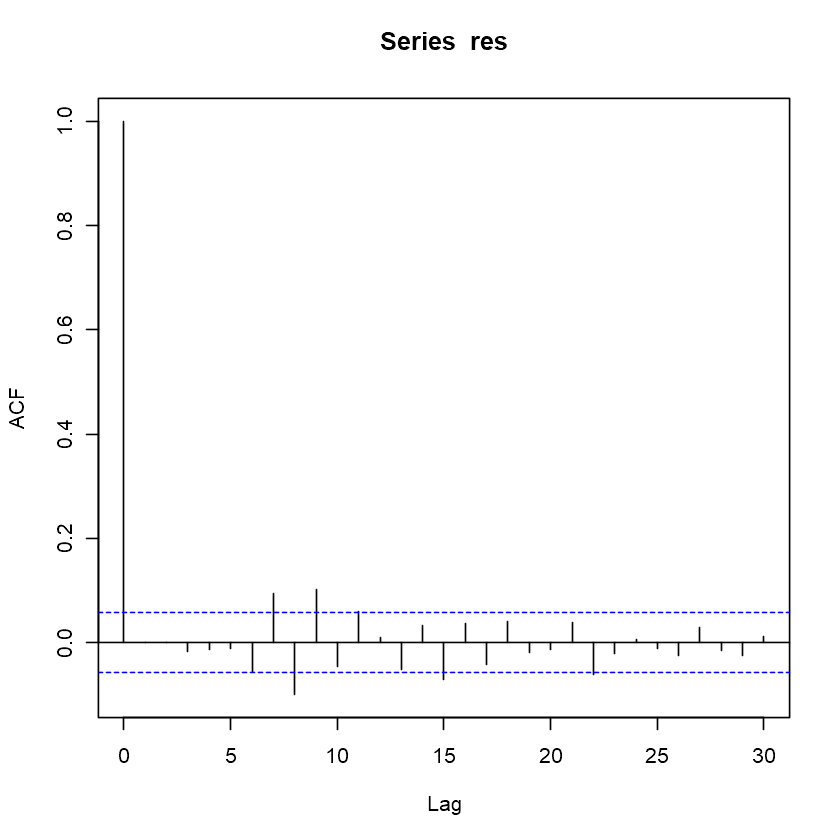


	Box-Ljung test

data:  res
X-squared = 0.69957, df = 5, p-value = 0.983



	Box-Ljung test

data:  res
X-squared = 40.989, df = 10, p-value = 1.133e-05



	Box-Ljung test

data:  res
X-squared = 61.78, df = 20, p-value = 3.764e-06


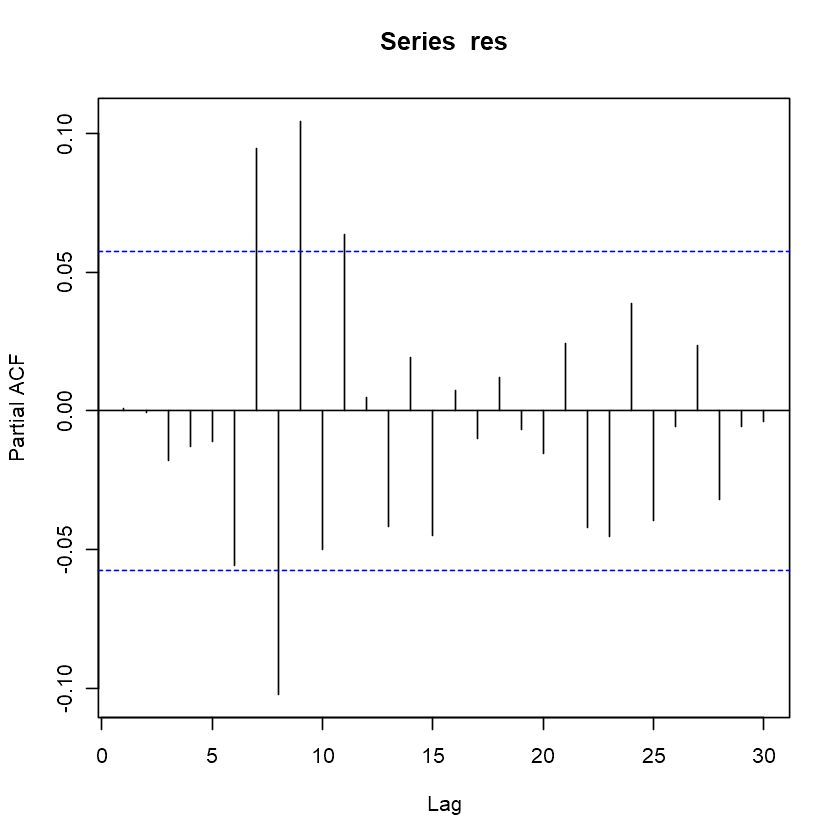

In [16]:
res = finalmodel$residuals
acf(res)
pacf(res)

Box.test(res,lag = 5,type = "Ljung")
Box.test(res,lag = 10,type = "Ljung")
Box.test(res,lag = 20,type = "Ljung")

Multiple comparison of AIC criteria obtained by different ARIMA models

In [17]:
AIC(arima(diff_data, order = c(1, 0, 0), seasonal = list(order = c(2,0,0), period = 12)),
    arima(diff_data, order = c(2, 0, 0), seasonal = list(order = c(2,0,0), period = 12)),
    arima(diff_data, order = c(0, 0, 3), seasonal = list(order = c(2,0,0), period = 12)))

,df,AIC
,<dbl>,<dbl>
"arima(diff_data, order = c(1, 0, 0), seasonal = list(order = c(2, 0, 0), period = 12))",5,15050.45
"arima(diff_data, order = c(2, 0, 0), seasonal = list(order = c(2, 0, 0), period = 12))",6,15049.28
"arima(diff_data, order = c(0, 0, 3), seasonal = list(order = c(2, 0, 0), period = 12))",7,15050.80


Residual Diagnostics


	Box-Ljung test

data:  finalmodel$residuals
X-squared = 61.78, df = 20, p-value = 3.764e-06


[1] 31.41043

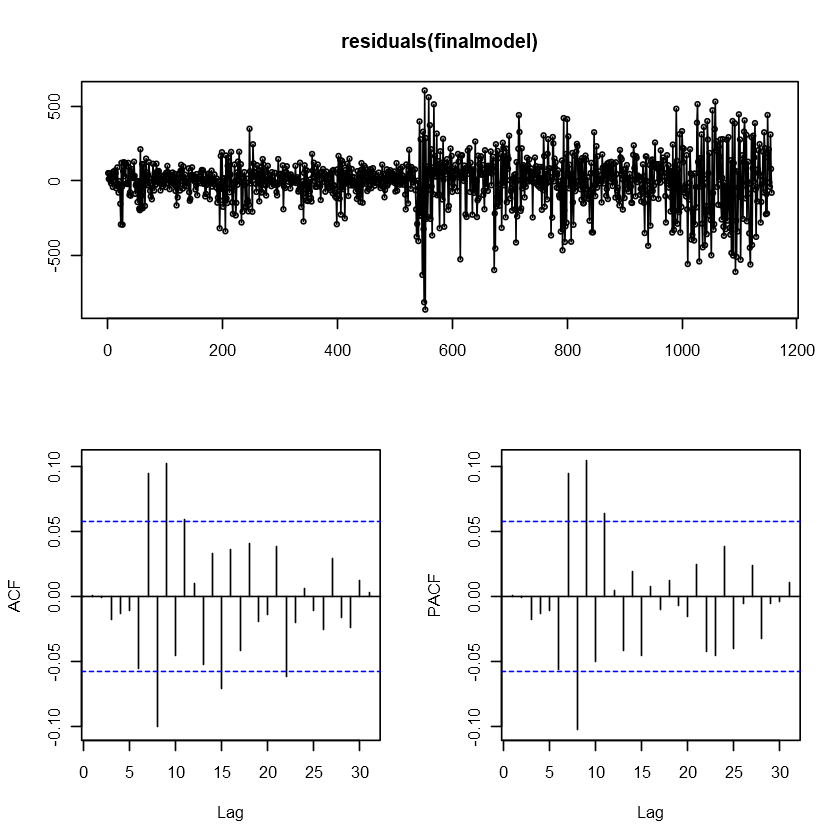

In [18]:
# Check whether the residuals look like white noise (Independent)
# p>0.05 then the residuals are independent (white noise)
tsdisplay(residuals(finalmodel))
Box.test(finalmodel$residuals, lag = 20, type = "Ljung-Box")
# p-values shown for the Ljung-Box statistic plot are incorrect so calculate
#critical chi squared value
# Chi-squared 20 d.f. and critical value at the 0.05
qchisq(0.05, 20, lower.tail = F)

In [19]:
#Forecasting
# predict the next 20 periods

(fit <- Arima(diff_data, order=c(2,0,0)))


Series: diff_data 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1     ar2    mean
      -0.1045  0.0517  4.8700
s.e.   0.0294  0.0293  4.5148

sigma^2 = 26184:  log likelihood = -7518.73
AIC=15045.46   AICc=15045.49   BIC=15065.67


	Ljung-Box test

data:  Residuals from ARIMA(2,0,0) with non-zero mean
Q* = 40.989, df = 7, p-value = 8.135e-07

Model df: 3.   Total lags used: 10



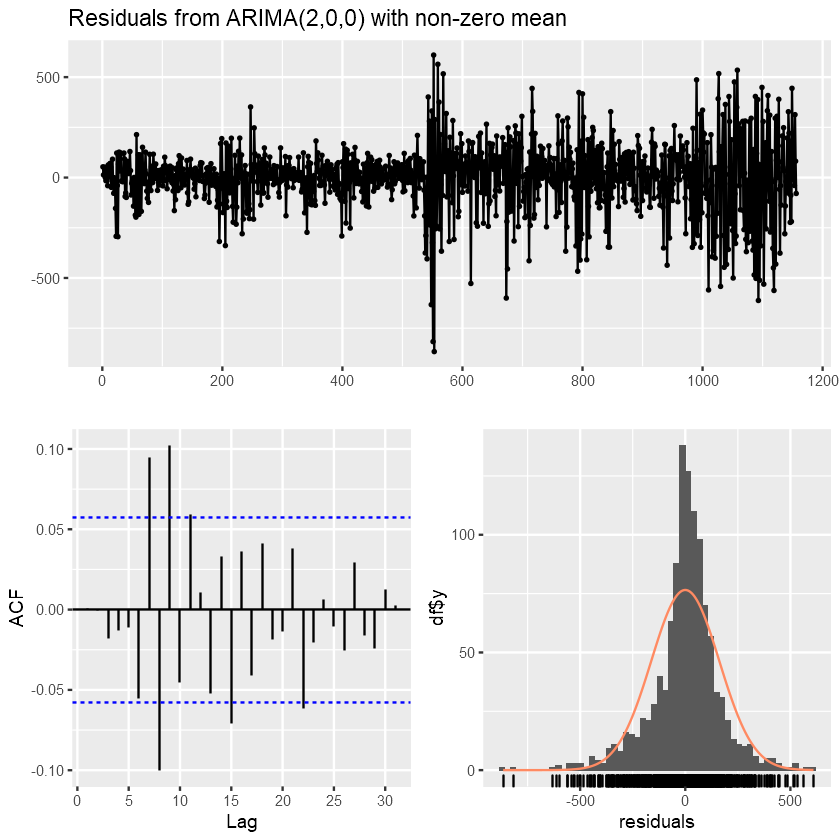

In [20]:
checkresiduals(fit)

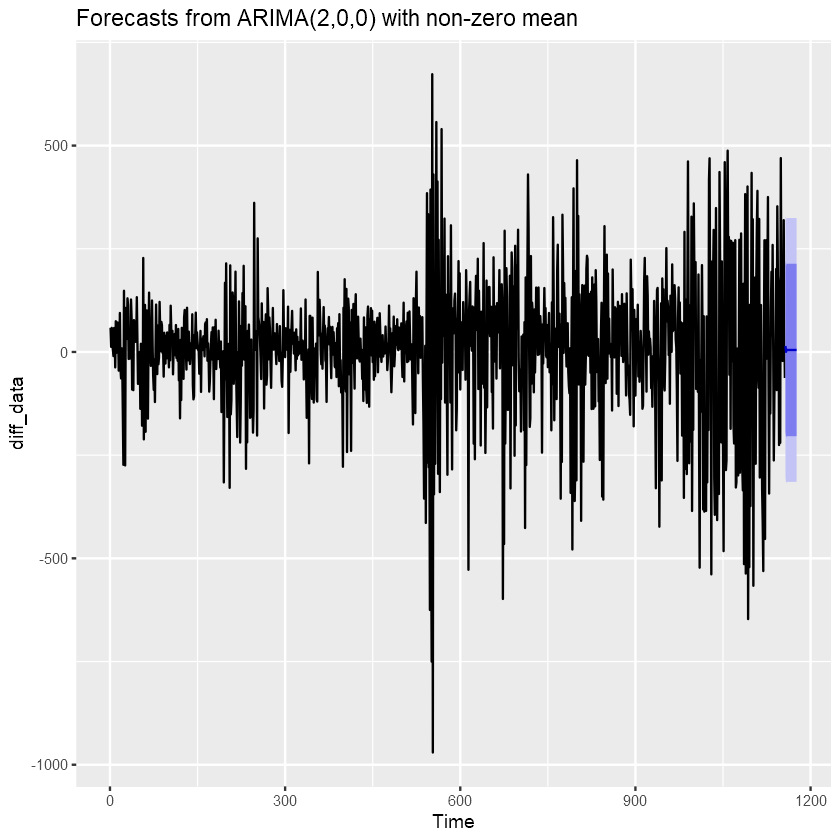

In [21]:
autoplot(forecast(fit,20))

Conclusion 

The Adj.close financial data was initially non-stationary. We had to differentiate once to make these data stationary. After several simulations and by comparing the AIC/BIC obtained for each model we retained the order (p=2, d=0,q=0) as being the best model. The Arima(2,0,0) model allowed us to model the prices of Adj.close of the NASDAQ company, and also to make forecasts. We had to check if the residuals are normally distributed with a zero mean and a constant variance 


Bibliography

Hyndman, RJ and Khandakar, Y. (2008). Automatic time series forecasting: the forecasting package for R . Journal of Statistical Software , 27 (1), 1-22